# 6.1
Применим знания на практике: с помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

Пригодится: 
* Как подключиться к ClickHouse через pandahouse?
* Как зайти в ClickHouse?
* Если у Вас есть вопросы, напишите сюда.

# 6.2
Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

Установить библиотеку  можно, запустив такую команду в ячейке вашего Jupyter Notebook:
* pip install pandahouse

In [1]:
#импортируем нужные либы
import pandahouse as ph
import pandas as pd

In [6]:
#объявляем параметры подключения
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [3]:
# запрос на количество строк можно задать в такой переменной:
query = """
SELECT 
    COUNT(*)
    FROM ldn_listings
"""
ph.execute(query, connection=connection)  # Запустить запрос

b'85207\n'

# 6.3
Выгрузите из таблицы данные о цене в зависимости от типа жилья. 

Необходимые столбцы:
* price – цена за ночь
* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы: 
+-----------------+------------+
| room_type       | price      |
+-----------------+------------+
| Private room    |         65 | 
| Entire home/apt |        100 | 
+-----------------+------------+

Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

In [23]:
query_2 = """
SELECT
       id,
       room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM {db}.ldn_listings
GROUP BY
       room_type, 
       id, 
       price
ORDER BY id ASC 
LIMIT 1000
"""

df = ph.read_clickhouse(query_2, connection=connection)
#пишем запрос, и записываем полученные данные из clickhouse в pandas dataframe

In [24]:
df.head()

,id,room_type,price
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0


In [42]:
df.query('room_type == "Private room"').price.quantile(0.75)

70.0

In [45]:
# Разбор
# Необходимые данные можно выгрузить следующим запросом:
query = '''
SELECT 
	room_type,
	toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM
	ldn_listings
limit 1000
'''

In [46]:
# Далее можно обработать датафрейм средствами python:
df = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()

In [48]:
df[df['room_type'] == 'Private room']

,room_type,price
2,Private room,70.0


In [ ]:
# Разбор
# Необходимые данные можно выгрузить следующим запросом: 

# query = '''
# SELECT 
# 	room_type,
# 	toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
# FROM
# 	ldn_listings
# ORDER BY
#         id ASC
# limit 1000
# '''

# df = ph.read_clickhouse(query, connection=connection)
# Далее необходимо посчитать 75 процентиль для цены по типу сдаваемого жилья:

# df = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()
# Нас интересует private room

# df[df['room_type'] == 'Private room']

# 6.4

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Hint: toFloat32OrNull(столбец)

Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Исходная таблица должна выглядеть так:

+-----------------+------------+--------------------+
| room_type       | price      |review_scores_rating|
+-----------------+------------+--------------------+
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |
+-----------------+------------+--------------------+
1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

Hint: документация sns.scatterplot

 

Если у Вас есть вопросы, напишите сюда.

Среди представленных ниже графиков выберите корректный:

In [50]:
# Разбор
# Необходимые данные можно выгрузить следующим запросом:
query = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM
    ldn_listings
WHERE review_scores_rating IS NOT NULL
limit 1000
'''
df = ph.read_clickhouse(query, connection=connection)

In [59]:
zzz = df.groupby('room_type', as_index = False).agg({'price':'mean', 'review_scores_rating':'mean'})
zzz

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


In [60]:
# импортируем библиотеку seaborn (для визуализации)
import seaborn as sns
# импортируем библиотеку matplotlib.pyplot (для визуализации)
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

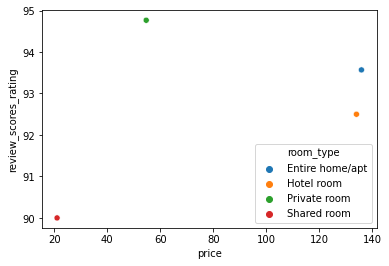

In [64]:
# график рассеивания
sns.scatterplot(x = 'price', y = 'review_scores_rating',  hue = 'room_type', data = zzz)

In [ ]:
# Разбор
# Для начала необходимо выгрузить запросом и обработать данные:

# query = '''
# SELECT 
# 	room_type,
#     toFloat32OrNull(review_scores_rating) as rsr,
# 	toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
# FROM
# 	ldn_listings
# where rsr is not null
# order by id
# limit 1000
# '''
# df = ph.read_clickhouse(query, connection=connection)
# df = df.groupby(['room_type'], as_index=False) \
#      .agg({'price': 'mean',
#            'rsr': 'mean'})
# Затем строим график, передавая в параметры необходимые значения:

# sns.scatterplot(data=df, x ='price', y='rsr', hue='room_type')
# Правильный ответ: 2

# 6.5

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

* host_id – идентификатор хозяина (уникальный)
* host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта:

                     "['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [78]:
query_6_5 = '''
SELECT 
    DISTINCT host_id,
    host_verifications
FROM
    {db}.ldn_listings
WHERE experiences_offered != 'none'
'''
df_6_5 = ph.read_clickhouse(query_6_5, connection=connection)

In [79]:
df_6_5.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [82]:
df_6_5.host_verifications = df_6_5.host_verifications.str.strip('[]').str.replace("'",'').str.split(',')
# Функция strip()  используется для  удаления начальных и конечных символов, переданных в неё. Удаляем [].
# .replace("'",'') заменяем "'" на ''
# .str.split(',') делим по ','
df_6_5.explode('host_verifications').host_verifications.value_counts()

email                     1345
 phone                    1345
 reviews                  1309
 government_id            1196
 jumio                    1115
 offline_government_id     469
 work_email                279
 facebook                  270
 selfie                    252
 identity_manual           227
 manual_offline             70
 google                     34
 kba                        27
phone                       16
 manual_online              16
 sent_id                     6
Name: host_verifications, dtype: int64

In [1]:
# Разбор
# Первоначально выгружаем данные при помощи запроса:

# q = """
# SELECT
#     DISTINCT host_id,
#     host_verifications
# FROM
#     ldn_listings
# WHERE
#     experiences_offered != 'none'
# """

# df = ph.read_clickhouse(q, connection=connection)
# Далее обрабатываем его с помощью pandas

# df = df \
#  .host_verifications \
#  .apply(lambda x: x.strip('[]').replace("'", '').split(', ')) \
#  .explode() \
#  .value_counts()
# Правильный ответ: 34

# 6.6
Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.

+------------------------+---------------------+-------------------+
| neighbourhood_cleansed | experiences_offered | experiences_count |
+------------------------+---------------------+-------------------+
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |
+------------------------+---------------------+-------------------+

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True).  

 

Если у Вас есть вопросы, напишите сюда.

Какой график получился?

In [114]:
q_6_6 = """
SELECT
        neighbourhood_cleansed, 
        experiences_offered,
        count(*) AS experiences_count
FROM
        ldn_listings
WHERE
        experiences_offered != 'none'
GROUP BY 
        neighbourhood_cleansed, 
        experiences_offered
ORDER BY 
        experiences_count DESC
LIMIT 100

"""
df_6_6 = ph.read_clickhouse(q_6_6, connection=connection)

In [115]:
df_6_6

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [116]:
df_6_6_pivot = df_6_6.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values ='experiences_count')

<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

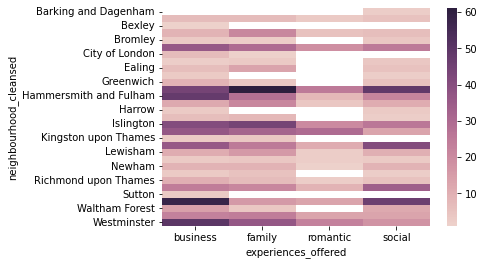

In [117]:
sns.heatmap(data = df_6_6_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

In [ ]:
# Разбор
# Для начала подготавливаем данные с количеством впечатлений по району и виду впечатления:

# q = """
# SELECT  
#     neighbourhood_cleansed,
#     experiences_offered,
#     COUNT(*) AS experiences_count
# FROM 
#     ldn_listings
# WHERE
#     experiences_offered != 'none'
# GROUP BY
#     neighbourhood_cleansed,
#     experiences_offered
# ORDER BY
#     experiences_count DESC
# LIMIT 100"""

# experiences = ph.read_clickhouse(q, connection=connection)
# Не забываем указать корректную сортировку.

# Далее составляем pivot таблицу и строим график:

# sns.heatmap(experiences.pivot(index= 'neighbourhood_cleansed', \
#  columns='experiences_offered', values = 'experiences_count'), \
#                cmap=sns.cubehelix_palette(as_cmap=True))
# Правильный ответ: 1

# 6.7

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')
Пример части результирующей таблицы:

+-----------------+------------+
| room_type       | price_corr |
+-----------------+------------+
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |
+-----------------+------------+
Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())
Если у Вас есть вопросы, напишите сюда.

Среди представленных графиков выберите два соответствующих.Картинка в полном размере: здесь

In [125]:
q_6_7 = """
SELECT
        room_type, 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr
FROM
        ldn_listings
WHERE
        experiences_offered != 'none'

"""
df_6_7 = ph.read_clickhouse(q_6_7, connection=connection)

In [135]:
df_6_7

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


<AxesSubplot:xlabel='price_corr'>

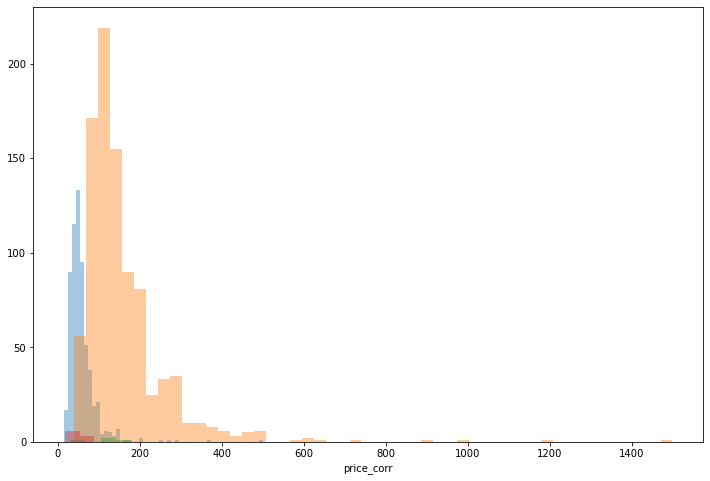

In [145]:
plt.figure(figsize=(12,8))
sns.distplot(df_6_7.query("room_type == 'Private room'").price_corr, kde = False)
sns.distplot(df_6_7.query("room_type == 'Entire home/apt'").price_corr, kde = False)
sns.distplot(df_6_7.query("room_type == 'Hotel room'").price_corr, kde = False)
sns.distplot(df_6_7.query("room_type == 'Shared room'").price_corr, kde = False)

In [151]:
import numpy as np

In [161]:
# находим логарифмированные значения
x1=np.log(df_6_7.query("room_type == 'Private room'").price_corr)
x2=np.log(df_6_7.query("room_type == 'Entire home/apt'").price_corr)
x3=np.log(df_6_7.query("room_type == 'Hotel room'").price_corr)
x3=np.log(df_6_7.query("room_type == 'Shared room'").price_corr)

NameError: name 'x4' is not defined

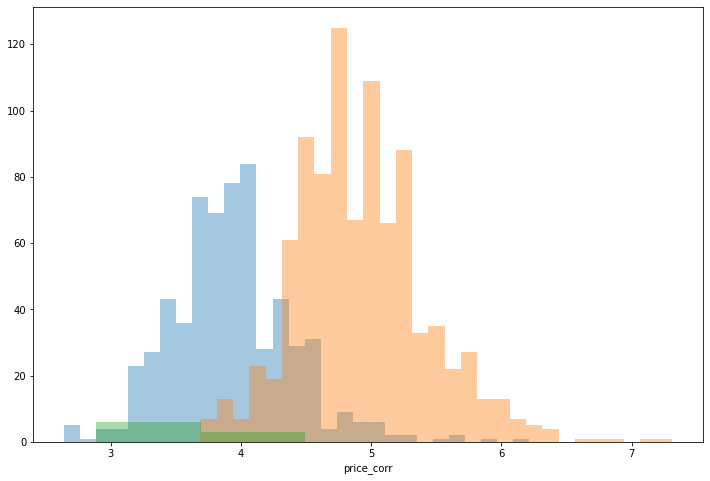

In [162]:
plt.figure(figsize=(12,8))
sns.distplot(x1, kde = False)
sns.distplot(x2, kde = False)
sns.distplot(x3, kde = False)
sns.distplot(x4, kde = False)

In [ ]:
# C помощью подобного запроса выгружаем информацию о стоимости жилья различного типа:

# query = '''
# SELECT
#     toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
#     room_type
# FROM
#     ldn_listings
# WHERE
#     experiences_offered != 'none'
# '''

# df = ph.read_clickhouse(query, connection=connection)
# Графики можно построить с помощью seaborn:

# sns.distplot((df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
# sns.distplot((df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
# sns.distplot((df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
# sns.distplot((df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
# plt.legend()
# plt.show()
# Для построения логарифмированных значений можно воспользоваться np.log():

# sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
# sns.distplot(np.log(df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
# sns.distplot(np.log(df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
# sns.distplot(np.log(df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
# plt.legend()
# plt.show()

#  6.8
Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Пример результирующей таблицы:

+-----------------+------------+------------+
| room_type       | price_corr |first_review|
+-----------------+------------+------------+
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |
+-----------------+------------+------------+
Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:

+-----------------+------------+------------+
| room_type       | avg_price  | year       |
+-----------------+------------+------------+
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |
+-----------------+------------+------------+
Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

Среди представленных ниже графиков выберите корректный.

 

In [176]:
q_6_8 = """
SELECT
        room_type, 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
        first_review
FROM
        ldn_listings
WHERE
        first_review > '2010-01-01'
LIMIT 1000

"""
df_6_8 = ph.read_clickhouse(q_6_8, connection=connection)

In [177]:
df_6_8

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [178]:
df_6_8.first_review

0      2010-08-18
1      2011-03-21
2      2016-03-05
3      2010-04-14
4      2010-10-16
          ...    
995    2012-11-07
996    2013-03-18
997    2012-09-17
998    2012-09-24
999    2012-11-26
Name: first_review, Length: 1000, dtype: object

In [173]:
df_6_8['year'] = df_6_8.first_review.apply(lambda x: x[:4])

In [174]:
df_6_8

,room_type,price_corr,first_review,year
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010
...,...,...,...,...
995,Private room,45.0,2012-11-07,2012
996,Private room,51.0,2013-03-18,2013
997,Entire home/apt,79.0,2012-09-17,2012
998,Entire home/apt,110.0,2012-09-24,2012


<AxesSubplot:xlabel='year', ylabel='price_corr'>

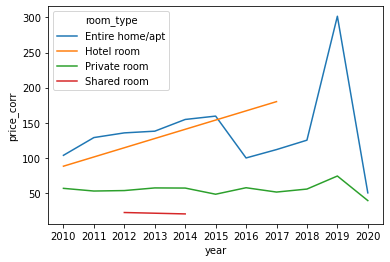

In [175]:
df_6_8 = df_6_8.groupby(['year', 'room_type'], as_index=False) \
    .agg({'price_corr': 'mean'})
sns.lineplot(data=df_6_8, hue='room_type', x = 'year', y='price_corr')

In [ ]:
# # Разбор
# # Выгружаем необходимые данные с помощью запроса:

# query = '''
# SELECT 
#         room_type
#     ,   toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr
#     ,   first_review
# FROM
#         ldn_listings
# where first_review > '2010-01-01'
# LIMIT 1000
# '''
# df = ph.read_clickhouse(query, connection=connection)
 

# # C помощью lambda - выражения и функции apply() получаем значение года:

# df['year'] = df.first_review.apply(lambda x: x[:4])
 

# # Рассчитываем среднюю стоимость в зависимости от года и типа жилья. Строим график:

# df = df.groupby(['year', 'room_type'], as_index=False) \
#     .agg({'price_corr': 'mean'})
# sns.lineplot(data=df, hue='room_type', x = 'year', y='price_corr')
# # Правильный ответ: 1

In [179]:
l='2010-08-18'

In [180]:
l[:4]

'2010'